In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm and IDs

In [328]:
%%time
ids_csv = 'data/ids.csv'
pmpm_p = 'data/PMPM.p'

treated_ids = pd.read_csv(ids_csv)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)


CPU times: user 8.88 s, sys: 11.2 s, total: 20 s
Wall time: 20 s


### Drop Unecessary data points

In [329]:
pmpm = pmpm[pmpm.MYR >= 202103].reset_index(drop = True)

In [330]:
pmpm.MBR_GNDR.replace(to_replace = {'F':0, 'M': 1}, inplace = True)
pmpm.MEDICAID_LOB.unique()

array(['Commercial', 'Medicare', 'Other', 'ASO', 'Medicaid-SSI',
       'Medicaid-TANF', 'Medicaid-Other', 'Medicaid-HARP', 'Medicaid-CHP'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [331]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

### Separate Treated Controls

In [332]:
pmpm.PERS_ID = pmpm.PERS_ID.astype(int)

In [333]:
%%time
id_filter = pmpm.PERS_ID.isin(list(treated_ids.values[:,0]))
treated, controls = pmpm[id_filter].reset_index(drop = True), pmpm[~id_filter].reset_index(drop = True)

CPU times: user 447 ms, sys: 336 ms, total: 783 ms
Wall time: 782 ms


In [324]:
treated = treated[treated.MYR >= 202108].reset_index(drop = True)

In [13]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE', 'ACUTE2']

In [14]:
def get_data(data_struct, cont):
    cont = cont.copy()
    keys = list(data_struct.keys())
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index = True)
    dat2 = dat1[['PERS_ID', 'MYR']]
    dat = pd.merge(dat2, cont, on = ['PERS_ID', 'MYR']).reset_index(drop = True)
    return dat

### General Configurations for All Matching Scenaria

In [15]:
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
hier_cols = None #['CC_DX_CNT']
hier_range = [1]
exact_match_dict = {'ACUTE':None, 'ACUTE2':None}
match_on = [ 'ALLOW_AMT', 'CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']
            


## Scenario 1 Rigorous

In [16]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':True}

rig_st, matched_data0 = matched_population(treated.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat1 = get_data(rig_st, controls)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:220845 before they were:220845
ACUTE None
ACUTE2 None
CPU times: user 24.9 s, sys: 16.8 s, total: 41.6 s
Wall time: 41.6 s


## Scenario 2 Non Rigorous

In [17]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 20,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':True}

Nrig_st, matched_data0 = matched_population(treated.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat2 = get_data(Nrig_st, controls)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:220845 before they were:220845
ACUTE None
ACUTE2 None
There were no matches for 0 out of 111 patients
CPU times: user 25.5 s, sys: 16.8 s, total: 42.3 s
Wall time: 42.3 s


### Scenario 3 Rigorous 6 months

In [18]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':False}

rig_st6, matched_data0 = matched_population(treated.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat3 = get_data(rig_st6, controls)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:220845 before they were:220845
ACUTE None
ACUTE2 None
CPU times: user 42.7 s, sys: 17.5 s, total: 1min
Wall time: 1min


## Scenario 4 Non Rigorous 6 Months

In [19]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 20,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':False}

Nrig_st6, matched_data0 = matched_population(treated.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat4 = get_data(Nrig_st6, controls)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:220845 before they were:220845
ACUTE None
ACUTE2 None
CPU times: user 43.2 s, sys: 17.3 s, total: 1min
Wall time: 1min


## Scenario 5 Medicaid Rigorous 

In [20]:
controlsM = controls[controls.LOB == 0].reset_index(drop = True)

In [21]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':True}

Mrig_st, matched_data0 = matched_population(treated.copy(), 
                                           controlsM.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat5 = get_data(Mrig_st, controlsM)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:53312 before they were:53312
ACUTE None
ACUTE2 None
CPU times: user 7.3 s, sys: 3.3 s, total: 10.6 s
Wall time: 10.6 s


## Scenario 6 Medicaid Non Rigorous

In [22]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 20,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':True}

MNrig_st, matched_data0 = matched_population(treated.copy(), 
                                           controlsM.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat6 = get_data(MNrig_st, controlsM)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:53312 before they were:53312
ACUTE None
ACUTE2 None
There were no matches for 0 out of 111 patients
CPU times: user 7.44 s, sys: 3.32 s, total: 10.8 s
Wall time: 10.8 s


### Scenario 7 Medicaid Rigorous 6 months

In [23]:
%%time
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':False}

Mrig_st6, matched_data0 = matched_population(treated.copy(), 
                                           controlsM.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat7 = get_data(Mrig_st6, controlsM)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:53312 before they were:53312
ACUTE None
ACUTE2 None
CPU times: user 8.88 s, sys: 3.45 s, total: 12.3 s
Wall time: 12.3 s


## Scenario 8 Medicaid Non Rigorous 6 Months

In [24]:
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 20,
                 'onset': "", "onset_val" : "", 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':False}

MNrig_st6, matched_data0 = matched_population(treated.copy(), 
                                           controlsM.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


dat8 = get_data(MNrig_st6, controlsM)

Mathcing Function: nearest_neighbor_func
After filtering control ids are:53312 before they were:53312
ACUTE None
ACUTE2 None


In [135]:
from utils import statistics_first_month

In [136]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con1, N1, controls_first_month = statistics_first_month(dat1, columns_to_match, return_array = True)
con1 = con1.T

con2, N2, controls_first_month = statistics_first_month(dat2, columns_to_match, return_array = True)
con2 = con2.T

con3, N3, controls_first_month = statistics_first_month(dat3, columns_to_match, return_array = True)
con3 = con3.T

con4, N4, controls_first_month = statistics_first_month(dat4, columns_to_match, return_array = True)
con4 = con4.T


con5, N5, controls_first_month = statistics_first_month(dat5, columns_to_match, return_array = True)
con5 = con5.T

con6, N6, controls_first_month = statistics_first_month(dat6, columns_to_match, return_array = True)
con6 = con6.T

con7, N7, controls_first_month = statistics_first_month(dat7, columns_to_match, return_array = True)
con7 = con7.T

con8, N8, controls_first_month = statistics_first_month(dat8, columns_to_match, return_array = True)
con8 = con8.T




CPU times: user 3.61 s, sys: 19.8 ms, total: 3.63 s
Wall time: 3.63 s


In [240]:
control_st = controls.loc[controls.MYR == 202108,columns_to_match].describe().loc[['mean', 'std']].T
control_st6, Nc6 = controls[columns_to_match].describe().loc[['mean', 'std']].T, len(controls)

control_stM = controlsM.loc[controlsM.MYR == 202108,columns_to_match].describe().loc[['mean', 'std']].T
control_stM6 = controlsM[columns_to_match].describe().loc[['mean', 'std']].T

In [315]:
control_st

mean          std
AGE_AT_MIDMONTH   49.398284    19.974061
ALLOW_AMT        301.558348  1462.108495
MBR_GNDR           0.434979     0.495756
CC_TOBACCO         0.098914     0.298548
CC_PRESSURE        0.011738     0.107705
CC_OBESITY         0.264908     0.441286
CC_HYPERTENSION    0.291309     0.454367
CC_HYPOTHYROID     0.068498     0.252600
CC_DX_CNT          2.821735     2.841143
ACUTE              0.011451     0.106397
ACUTE2             0.042876     0.212402

In [137]:
pm_st = pmpm.loc[pmpm.MYR == 202108,columns_to_match].describe().loc[['mean', 'std']].T
pm_st6 = pmpm[columns_to_match].describe().loc[['mean', 'std']].T

In [138]:
import scipy.stats as sts

args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [242]:
def SMD(treated_stats, control_stats, Nt, Nc, pooled = False, pool_std = None, Npc = None):
    
    if pooled:
        pooled = ((Nt-1)*treated_stats['std']+(Npc-1)*pool_std['std'])/(Nt+Npc)

        return np.abs(treated_stats['mean']- control_stats['mean'])/(pooled)
    else:
        return np.abs(treated_stats['mean']- control_stats['mean'])/(treated_stats['std'])

        
    

### Calculate standarized mean difference

In [243]:
SMDS = pd.DataFrame()
SMDS_noP = pd.DataFrame()
variances = pd.DataFrame()
for i in range(1, 9):
    SMDS = pd.concat(( SMDS,eval('SMD(tr_desc0, con'+str(i)+', Ntr, N1,pooled = True, pool_std = control_st6 , Npc = Nc6 )')), axis = 1)
    SMDS_noP = pd.concat(( SMDS_noP,eval('SMD(tr_desc0, con'+str(i)+', Ntr, N1)')), axis = 1)

    variances = pd.concat((variances, eval('tr_desc0["std"]/con'+str(i)+'["std"]') ), axis = 1)

In [244]:
smds_cols = ['Rig', 'NonRig', 'Rig6', 'NonRig6', 'Rig-Med', 'NonRig-Med', 'Rig-Med6','NonRig-Med6', 'General Population', 'General population 6 Months']

In [245]:
SMDS = pd.concat(( SMDS, SMD(tr_desc0, pm_st, Ntr, len(pmpm[pmpm.MYR == 202108]), pooled = True, pool_std = control_st6 , Npc = Nc6),
                  SMD(tr_desc0, pm_st6, Ntr, len(pmpm), pooled = True, pool_std = control_st6 , Npc = Nc6)), axis = 1)
SMDS.columns = smds_cols

SMDS_noP = pd.concat(( SMDS_noP, SMD(tr_desc0, pm_st, Ntr, len(pmpm[pmpm.MYR == 202108])), SMD(tr_desc0, pm_st6, Ntr, len(pmpm))), axis = 1)
SMDS_noP.columns = smds_cols

variances = pd.concat((variances, tr_desc0["std"]/pm_st['std'],tr_desc0["std"]/pm_st6['std']), axis = 1)
variances.columns = smds_cols

In [246]:
alli = pd.concat((tr_desc0['mean'], con1['mean'], con2['mean'], con3['mean'], con4['mean'], con5['mean'], con6['mean'], con7['mean'], con8['mean'], pm_st['mean'], pm_st6['mean']),
                 axis = 1, keys = ['Treated', 'Rig', 'NonRig', 'Rig6', 'NonRig6', 'Rig-Med', 'NonRig-Med', 'Rig-Med6','NonRig-Med6', 'General Population', 'General population 6 Months'] )

!pip3 install jinja2 --user

## Standarized Mean Differences-Variance of the treated

In [247]:
SMDS.columns

Index(['Rig', 'NonRig', 'Rig6', 'NonRig6', 'Rig-Med', 'NonRig-Med', 'Rig-Med6', 'NonRig-Med6', 'General Population', 'General population 6 Months'], dtype='object')

In [248]:
SMDS.style.set_caption('Standarized Mean Difference on Matching Date(Pooled Variance)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '30px')
    ]
}])

In [250]:
SMDS_noP.style.set_caption('Standarized Mean Difference on Matching Date(Treated Variance)').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '30px')
    ]
}])

## Std Ratio

In [251]:
variances.style.set_caption('Std Ratio').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '30px')
    ]
}])

## Means 

In [252]:
alli.style.set_caption('Means on Matching Date').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '30px')
    ]
}])

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mtp

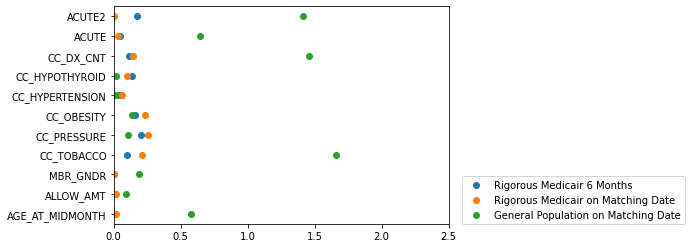

In [254]:
fig, ax = plt.subplots()
# ['Treated', 'Rig', 'NonRig', 'Rig6', 'NonRig6', 'Rig-Med', 'NonRig-Med', 'Rig-Med6','NonRig-Med6', 'General Population At MM', 'General population 6 Months'] )
ax.scatter(x= SMDS['Rig-Med6'].iloc[:].values, y = np.arange(1, len(SMDS)+1))
ax.scatter(x= SMDS['Rig-Med'].iloc[:].values, y = np.arange(1, len(SMDS)+1))
ax.scatter(x= SMDS['General Population'].iloc[:].values, y = np.arange(1, len(SMDS)+1))

ax.set_yticks(np.arange(1, len(SMDS)+1))
ax.set_yticklabels(list(SMDS.index))
ax.set_xlim((0,2.5))
ax.legend(['Rigorous Medicair 6 Months','Rigorous Medicair on Matching Date', 'General Population on Matching Date'],loc=(1.04,0))
#ax.legend(loc=(1.04,0))
fig.show()

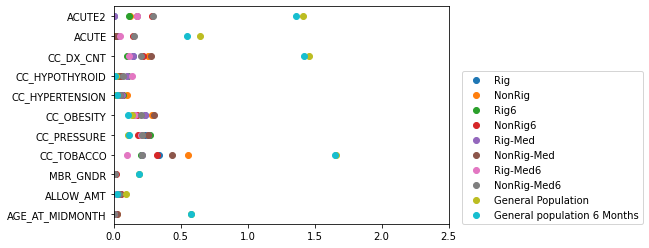

In [255]:
fig, ax = plt.subplots()
for col in SMDS.columns:
    ax.scatter(x= SMDS[col].iloc[:].values, y = np.arange(1, len(SMDS)+1))
    
ax.set_yticks(np.arange(1, len(SMDS)+1))
ax.set_yticklabels(list(SMDS.index))
ax.set_xlim((0,2.5))
ax.legend(SMDS.columns,loc=(1.04,0))
#ax.legend(loc=(1.04,0))
fig.show()

### Standarized means Graph

In [ ]:
#control_stM6, tr_desc0, con7

In [265]:
pooled = (tr_desc0['std']*Ntr + control_stM6['std']*len(controlsM))/(Ntr+len(controlsM))

In [267]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = control_stM6['mean']/pooled
stdMeans['MControls'] = con7['mean']/pooled


In [296]:
list(stdMeans.index)

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE',
 'ACUTE2']

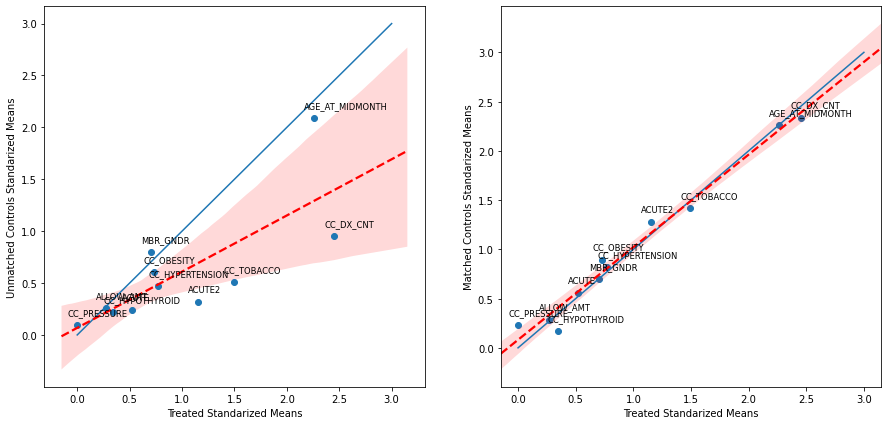

In [311]:
f, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.show()

### Create the Scenaria Matrix

In [30]:
all_ids = set()
data_ids = []
for i in range(1,9):
    all_ids |= set(eval('dat'+str(i)+'.PERS_ID.unique()'))
    data_ids.append(eval('dat'+str(i)+'.PERS_ID.unique()'))

In [31]:
pd_ids = pd.DataFrame(all_ids, columns = ['PERS_ID'])

In [32]:
names = ['Rigorous', 'Non-Rigorous', 'Rigorous-6-months', 'Non-Rigorous-6-Month', 'Rigorous-Medicaid', 'Non-Rigorous-Medicaid', 'Rigorous-Medicaid-6','Non-Rigorous-Medicaid-6-Months']

In [33]:
for name, id_set in zip(names, data_ids):
    pd_ids[name] = 0
    filt = pd_ids.PERS_ID.isin(list(id_set))
    
    pd_ids.loc[filt,name] = 1

In [34]:
pd_ids.sum(axis = 0)

PERS_ID                           14352629276
Rigorous                                  540
Non-Rigorous                             1999
Rigorous-6-months                         470
Non-Rigorous-6-Month                     1546
Rigorous-Medicaid                         530
Non-Rigorous-Medicaid                    1898
Rigorous-Medicaid-6                       441
Non-Rigorous-Medicaid-6-Months           1480
dtype: int64

In [35]:
for i,id_set in enumerate(data_ids):
    print(len(id_set), eval('len(dat'+str(i+1)+')'))

540 555
1999 2201
470 555
1546 2220
530 555
1898 2189
441 555
1480 2220


In [36]:
pd_ids.to_csv('matched_ids_scenaria.csv')

In [37]:
pd_ids

PERS_ID  Rigorous  Non-Rigorous  Rigorous-6-months  Non-Rigorous-6-Month  Rigorous-Medicaid  Non-Rigorous-Medicaid  Rigorous-Medicaid-6  Non-Rigorous-Medicaid-6-Months
0     3096581         0             1                  0                     0                  0                      1                    0                               0
1     2932745         0             1                  0                     0                  0                      0                    0                               0
2     3047436         0             1                  0                     0                  0                      0                    0                               0
3     3235853         0             1                  0                     0                  0                      0                    0                               0
4     2965523         0             0                  0                     0                  1                      1                    0                               0
...       ...       ...           ...                ...                   ...                ...                    ...                  ...                             ...
3967  4399083         0             0                  0                     0                  0                      0                    0                               1
3968  3973101         0             1                  0                     0                  0                      1                    0                               0
3969  4243438         1             1                  1                     1                  1                      1                    1                               1
3970  3104756         0             1                  0                     1                  1                      1                    0                               1
3971  3809279         1             1                  0                     1                  0                      0                    0                               0

[3972 rows x 9 columns]